In [1]:
import os
import ruamel.yaml as yaml
import matplotlib.pyplot as plt
import numpy as np

## Obligatory paths

In [2]:
path_to_local_folder = os.path.expanduser('data_samples')
filter_include = ["synth", "A04hm_H1","nocond"]
filter_exclude = ["failed"]

conf_name = "common_files/config_mcmc_bayes.yaml"

# načtení dat a formatovani dat

In [3]:
from raw_data import MultiRawData
from results_aggregator import get_subfolder_paths_processed, filter_datasets

subfolders = get_subfolder_paths_processed(path_to_local_folder)
subfolders_filt = filter_datasets(subfolders, filter_include, filter_exclude)

all_raw_data = MultiRawData()
all_raw_data.load_from_folders_hdf5(subfolders_filt)
# load yaml config from the first folder in the list, it will be used for likelihood evaluation
conf = yaml.safe_load(open(os.path.join(subfolders_filt[0], conf_name), 'r'))
subfolders_filt

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


['data_samples/borehole_H1/synth_A04hm_H1_nocond_20230419',
 'data_samples/borehole_H1/synth_A04hm_H1_nocond_nocorr_20230602',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230618a',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230618b',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230618c',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230619',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230619b',
 'data_samples/borehole_H1_proposal_std/synth_A04hm_H1_nocond_nocorr_20230619c']

## Filtrovaní dat

In [4]:
# filter data so only those with model are used and only ones with tag 1 = coverged
raw_data_filtered = all_raw_data.filter(types=[0, 2], tags=[1])
raw_data_filtered.print_statistics()

raw data: no_samples 167632
raw data: no_nonconverging 0
raw data: p (167632, 8)
raw data: w (167632, 1)
raw_data: np.sum(weights): 1950105.0
raw_data: all_sizes: {'types': (167632,), 'stages': (167632,), 'chains': (167632,), 'tags': (167632,), 'parameters': (167632, 8), 'observations': (167632, 26), 'parameters_normalized': (167632, 8), 'weights': (167632, 1), 'run_ids': (167632,)}


## Rekonstrukce modelu šumu pro výpočet likelihoodu

In [5]:
import surrDAMH_gaussian_process as gp

def compute_log_likelihood_all(data):
    # reconstruct covariance of the noise
    cov_mat = gp.assemble_covariance_matrix(conf['noise_model'])

    # rewritten likelihood for our model
    def get_log_likelihood_multivariate(observations, G_sample,noise_std):
        v = observations - G_sample.ravel()
        invCv = np.linalg.solve(noise_std,v)
        return -0.5*np.dot(v,invCv)

    # measurement from conf
    y_orig = np.array(conf['problem_parameters']['observations'])

    log_likelihood = np.zeros((data.shape[0],1))
    for idx,obs in enumerate(data):
        log_likelihood[idx] = get_log_likelihood_multivariate(obs,y_orig,cov_mat)
    
    return log_likelihood

## Vytvoření datasetu pro trénování a testování

In [6]:
data = raw_data_filtered.parameters_normalized
obs = raw_data_filtered.observations

obs_likelihood = compute_log_likelihood_all(obs)


9.357622968840175e-14 2.061153622438558e-09 4.5399929762484854e-05 0.01831563888873418


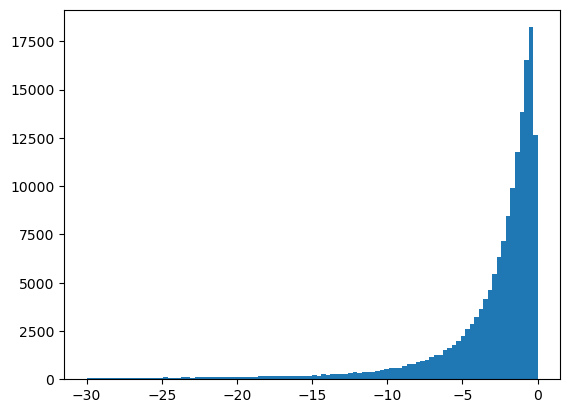

In [7]:
_ = plt.hist(obs_likelihood, bins=100, range=(-30, 0))
print(np.exp(-30), np.exp(-20), np.exp(-10), np.exp(-4))

In [8]:
# filter only data and obs with obs_likelihood > -10
data_filt = data[obs_likelihood.ravel() > -10, :]  # type: ignore
obs_filt = obs[obs_likelihood.ravel() > -10, :]  # type: ignore
obs_filt.shape

(151231, 26)

In [9]:

from sklearn.model_selection import train_test_split

input_data = data_filt
output_data = obs_filt

# rozdělit data na trénovací a testovací set
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.9, random_state=42)

likelihood_train = compute_log_likelihood_all(y_train)
likelihood_test = compute_log_likelihood_all(y_test)
likelihood_train.shape

(15123, 1)

In [10]:
# simulace acceptance probability

def acceptance_prob_all(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_test[idx]

    alpha_s = np.minimum(likelihood_test + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

def acceptance_prob_all_train(prediction_likelihood):
    # create random permutation of filt_likelihood,acc_likelihood
    idx = np.random.permutation(len(prediction_likelihood))
    old_pred = prediction_likelihood[idx]
    old_test = likelihood_train[idx]

    alpha_s = np.minimum(likelihood_train + old_pred - prediction_likelihood - old_test,0)

    return np.exp(alpha_s)

In [11]:
def plot_results_only_likelihood_(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.01, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all)
    mean_acceptance = np.mean(alpha_all)
    axs[1].set_title(f'mean acceptance = {mean_acceptance}')
    plt.show()

def plot_results_only_likelihood(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # First subplot
    axs[0].scatter(likelihood_test, res_surr, alpha=0.01, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)
    axs[0].set_xlabel('Exact')
    axs[0].set_ylabel('Meta-model')
    axs[0].set_title('Log-likelihood approximation')

    # Second subplot
    alpha_all = acceptance_prob_all(res_surr)
    axs[1].hist(alpha_all, bins=30, density=True)
    mean_acceptance = np.mean(alpha_all)
    rounded_mean_acceptance = round(mean_acceptance, 3)
    axs[1].text(0.05, 0.95, f'Mean Acceptance = {rounded_mean_acceptance:.3f}', 
                transform=axs[1].transAxes, verticalalignment='top')
    axs[1].set_xlabel('Probability of acceptance')
    axs[1].set_ylabel('Distribution of probability of acceptance')
    axs[1].set_title('Simmulated probability of acceptance during DAMH')
    
    plt.show()

def plot_results_all(res_surr):
    plot_results_only_likelihood(compute_log_likelihood_all(res_surr))
    
def plot_results_only_likelihood_train(res_surr):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # First subplot
    axs[0].scatter(likelihood_train, res_surr, alpha=0.01, marker='.')
    axs[0].plot([-10,0],[-10,0], color='red')
    axs[0].set_ylim(-10, 0)
    axs[0].set_xlim(-10, 0)
    axs[0].set_xlabel('Exact')
    axs[0].set_ylabel('Meta-model')
    axs[0].set_title('Log-likelihood approximation')

    # Second subplot
    alpha_all = acceptance_prob_all_train(res_surr)
    axs[1].hist(alpha_all, bins=30, density=True)
    mean_acceptance = np.mean(alpha_all)
    rounded_mean_acceptance = round(mean_acceptance, 3)
    axs[1].text(0.05, 0.95, f'Mean Acceptance = {rounded_mean_acceptance:.3f}', 
                transform=axs[1].transAxes, verticalalignment='top')
    axs[1].set_xlabel('Probability of acceptance')
    axs[1].set_ylabel('Distribution of probability of acceptance')
    axs[1].set_title('Simmulated probability of acceptance during DAMH')
    
    plt.show()

def plot_results_all_train(res_surr):
    plot_results_only_likelihood_train(compute_log_likelihood_all(res_surr))

In [13]:
y_train.shape

(15123, 26)

In [152]:
import sched
import torch
import torch.nn as nn
import torch.optim as optim

# Check if CUDA is available and set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        # Encoder: Linear layers with ReLU activation
        self.encoder = nn.Sequential(
            nn.Linear(26, 200),
            nn.Tanh(),            
            nn.Linear(200, 4),
            nn.Sigmoid()
        )
        
        # Decoder: Linear layers with ReLU activation
        self.decoder = nn.Sequential(
            nn.Linear(4, 200),
            nn.Tanh(),
            nn.Linear(200, 26)
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Assume data_array is your numpy array of shape (n, 26)
data_array = y_train # replace with your data
tensor_data = torch.tensor(data_array, dtype=torch.float32).to(device)

# Initialize the autoencoder, optimizer, and loss function
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=200, verbose=True, factor=0.5)

# Training the autoencoder
epochs = 200000
for epoch in range(epochs):
    # Zero the gradients
    optimizer.zero_grad()
    
    # Forward pass
    outputs = model(tensor_data)
    
    # Compute loss
    loss = criterion(outputs, tensor_data)
    scheduler.step(loss)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if epoch % 1000 == 0:
        print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, learning rate: {optimizer.param_groups[0]["lr"]:.5f}')

# Using the encoder and decoder separately
# Encoding
with torch.no_grad():
    encoded_data = model.encoder(tensor_data)
    print('Encoded Data: ', encoded_data.cpu())  # move tensor to CPU for printing

# Decoding
with torch.no_grad():
    decoded_data = model.decoder(encoded_data)
    print('Decoded Data: ', decoded_data.cpu())  # move tensor to CPU for printing


cuda
Epoch [0/200000], Loss: 8919.4219, learning rate: 0.00010
Epoch [1000/200000], Loss: 6225.1099, learning rate: 0.00010
Epoch [2000/200000], Loss: 3938.8308, learning rate: 0.00010
Epoch [3000/200000], Loss: 2615.4746, learning rate: 0.00010
Epoch [4000/200000], Loss: 1859.9797, learning rate: 0.00010
Epoch [5000/200000], Loss: 1419.5497, learning rate: 0.00010
Epoch [6000/200000], Loss: 1132.3274, learning rate: 0.00010
Epoch [7000/200000], Loss: 912.1580, learning rate: 0.00010
Epoch [8000/200000], Loss: 732.1367, learning rate: 0.00010
Epoch [9000/200000], Loss: 584.1930, learning rate: 0.00010
Epoch [10000/200000], Loss: 447.4901, learning rate: 0.00010
Epoch [11000/200000], Loss: 345.7723, learning rate: 0.00010
Epoch [12000/200000], Loss: 262.2643, learning rate: 0.00010
Epoch [13000/200000], Loss: 194.0602, learning rate: 0.00010
Epoch [14000/200000], Loss: 143.6065, learning rate: 0.00010
Epoch [15000/200000], Loss: 110.3886, learning rate: 0.00010
Epoch [16000/200000], Los

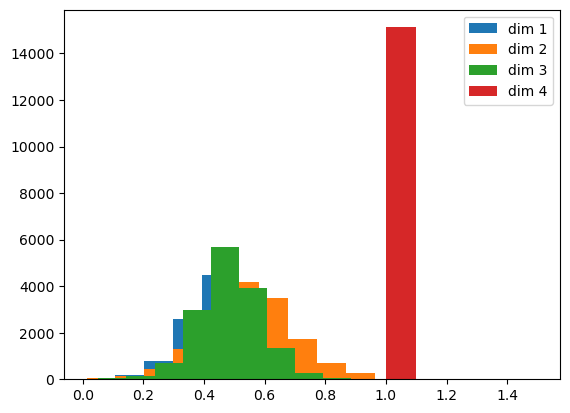

In [153]:
for i in range(4):
    plt.hist(encoded_data.cpu().numpy()[:,i], bins=10)
    
plt.legend(['dim 1', 'dim 2', 'dim 3', 'dim 4', 'dim 5'])

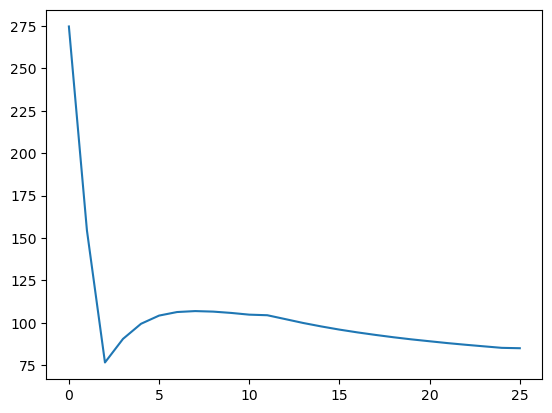

In [219]:
tmp = torch.tensor(np.random.rand(1,4), dtype=torch.float32).to(device)
tmp2 = model.decoder(tmp)
plt.plot(tmp2.to('cpu').detach().numpy().ravel())